#### 사용자 정의 데이터셋과 모델과 학습
- iris.csv ==> 사용자 정의 데이터셋
- DNN 모델 ==> 사용자 정의 모델

[1] 모듈 로딩 및 데이터 준비 <hr>

In [38]:
## 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.classification import F1Score
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from sklearn.preprocessing import LabelEncoder       # 타겟 컬럼 수치화
from sklearn.model_selection import train_test_split

In [39]:
# 텐서 저장 및 실행 위치 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
# 데이터
DATA_FILE = '../Data/iris.csv'

In [41]:
# CSV ==> DataFrame
irisDF=pd.read_csv(DATA_FILE)
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


In [42]:
# 타겟 컬럼 수치화 ===> LabelEncoder
encoder=LabelEncoder()
encoder.fit(irisDF['variety'])
irisDF['variety']=encoder.transform(irisDF['variety'])

In [43]:
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0


[2] 사용자 정의 데이터셋 클래스 생성 <hr>

In [44]:
# ----------------------------------------------------------------
# 클래스이름 : 학습용 데이터셋 텐서화 및 전처리
# 클래스목적 : CustomDataSet
# 부모클래스 : torch.utils.data.DataSet
# 매개  변수 : featureDF, targetDF
# ----------------------------------------------------------------
class CustomDataSet(Dataset):
    # 데이터 로딩 및 전처리 진행과 인스턴스 생성 메서드
    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]

    # 데이터의 개수 반환 메서드
    def __len__(self):
        return self.n_rows
    
    # 특정 index의 데이터와 타겟 반환 메서드 => Tensor 반환! 
    def __getitem__(self, idx):
        featureTS=torch.FloatTensor(self.featureDF.iloc[idx].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[idx].values)
        return featureTS, targetTS

[3] 데이터셋 인스턴스 생성 <hr>

In [45]:
featureDF, targetDF = irisDF[irisDF.columns[:-1]], irisDF[[irisDF.columns[-1]]]

print(f'featureDF(shape) => {featureDF.shape}, targetDF(shape) => {targetDF.shape}')

featureDF(shape) => (150, 4), targetDF(shape) => (150, 1)


In [46]:
irisDS = CustomDataSet(featureDF, targetDF)

In [47]:
# IRIS 데이터셋 속성
irisDS.n_features, irisDS.n_rows

(4, 150)

[4] 데이터로더 인스턴스 생성

In [48]:
## 필요한 것 : Dataset 인스턴스, Batch_size=1(default)
irisDL = DataLoader(irisDS, batch_size=3)

[5] 모델 준비 <hr>

In [49]:
# ----------------------------------------------------------------------------
# 모델 이름  : CustomModel
# 부모클래스 : nn.Module
# 매개 변수  : in_in, out_out, h_inout, h_cnt
# 모델 구조
# - 입력층 : 입력 4개   출력 10개 AF ReLU
# - 은닉층 : 입력 10개  출력 30개 AF ReLU -> (보완) Leaky ReLU
# - 출력층 : 입력 30개  출력 3개 AF분류 - 다중 Softmax
# ----------------------------------------------------------------------------
class CustomModel(nn.Module):

    # 모델 구성 및 인스턴스 생성 메서드 (콜백함수 callback func)
    def __init__(self):
        # 부모클래스 생성
        super().__init__()
        # 자식클래스의 인스턴스 속성 설정
        self.in_layer=nn.Linear(4,10)
        self.hidden_layer=nn.Linear(10,30)
        self.out_layer=nn.Linear(30,3) # 0과 나머지, 1과 나머지, 2와 나머지
    
    # 순방향 학습 메서드
    def forward(self, x):
        y=F.relu(self.in_layer(x))
        y=F.relu(self.hidden_layer(y))
        return self.out_layer(y)

In [50]:
### 모델 인스턴스 생성
model = CustomModel()
print(model)
summary(model, input_size=(1000,4))

CustomModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=30, bias=True)
  (out_layer): Linear(in_features=30, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [1000, 3]                 --
├─Linear: 1-1                            [1000, 10]                50
├─Linear: 1-2                            [1000, 30]                330
├─Linear: 1-3                            [1000, 3]                 93
Total params: 473
Trainable params: 473
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.02
Forward/backward pass size (MB): 0.34
Params size (MB): 0.00
Estimated Total Size (MB): 0.36

In [51]:
# 모델 파라미터 즉, W와 b확인
for n in model.named_parameters(): print(n)

('in_layer.weight', Parameter containing:
tensor([[ 0.3284,  0.0925,  0.2981, -0.4118],
        [-0.1391,  0.0050,  0.4125, -0.1782],
        [ 0.3224, -0.3045,  0.3904, -0.1500],
        [ 0.1432,  0.0217,  0.1639,  0.4144],
        [-0.0936, -0.1181, -0.3626,  0.2926],
        [-0.3655, -0.2340,  0.3428,  0.0569],
        [-0.4390, -0.4713,  0.3761,  0.2694],
        [-0.0275,  0.0052,  0.0844,  0.0958],
        [-0.1074, -0.2670, -0.4383, -0.2087],
        [-0.3256,  0.1404, -0.4229, -0.2343]], requires_grad=True))
('in_layer.bias', Parameter containing:
tensor([-0.0658,  0.0954,  0.4052,  0.1812, -0.2917,  0.0558,  0.1827,  0.4406,
         0.1264,  0.4784], requires_grad=True))
('hidden_layer.weight', Parameter containing:
tensor([[ 0.0031,  0.0400, -0.0225, -0.1243, -0.2204,  0.1995,  0.0906, -0.0015,
          0.0184,  0.0357],
        [-0.1512, -0.1420, -0.0401, -0.2096, -0.0757, -0.0433,  0.2070,  0.1649,
         -0.0004, -0.0198],
        [ 0.0854,  0.1465, -0.1448,  0.1412,

[6] 학습 <hr>

In [52]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
optim=optim.Adam(model.parameters(), lr=0.1)

In [53]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetDF,
                                                    test_size=0.2,
                                                    random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    random_state=5)

print(f'[feature] X_TRAIN: {X_train.shape}, X_TEST: {X_test.shape}, X_VAL: {X_val.shape}')
print(f'[target] Y_TRAIN:{y_train.shape}, Y_TEST: {y_test.shape}, Y_VAL: {y_val.shape}')

[feature] X_TRAIN: (96, 4), X_TEST: (30, 4), X_VAL: (24, 4)
[target] Y_TRAIN:(96, 1), Y_TEST: (30, 1), Y_VAL: (24, 1)


In [79]:
EPOCH=100                                       # 처음~끝까지 공부하는 횟수
BATCH_SIZE=10                                   # 1 에포크에서 한 번 학습할 분량 크기
BATCH_CNT=X_train.shape[0]//BATCH_SIZE          # 1 에포크에서 총 학습 횟수이면서 업데이트 횟수

print(f'EPOCH: {EPOCH}, BATCH_SIZE: {BATCH_SIZE}, BATCH_CNT: {BATCH_CNT}')

EPOCH: 100, BATCH_SIZE: 10, BATCH_CNT: 9


In [80]:
# ----------------------------------------------------------------
# 함수기능 : 검증 및 테스트 진행 후 손실값과 성능지표값 반환 함수
# 함수이름 : testing
# 매개변수 : val_feature, val_target
# 반 환 값 : 손실값과 성능지표값
# ----------------------------------------------------------------
def testing(val_feature, val_target):
    # Tensor화
    val_feature = torch.FloatTensor(val_feature.values).to(DEVICE)
    val_target = torch.FloatTensor(val_target.values).to(DEVICE)
    val_target = val_target.reshape(-1).long()
    with torch.no_grad():
        # 학습 진행
        pre_y = model(val_feature)

        # 손실 계산
        loss=nn.CrossEntropyLoss()(pre_y, val_target)

        # 점수 추출
        score = F1Score(task="multiclass", num_classes=3)(pre_y, val_target)

    # 손실값과 성능지표값 반환
    return loss, score

In [127]:
# ----------------------------------------------------------------
# 함수기능 : 학습 진행 후 손실값과 성능지표값 반환 함수
# 함수이름 : training
# 매개변수 : model, dataTS, targetTS, batch_cnt, batch_size=3
# 반 환 값 : 에포크당 손실값과 성능지표값
# ----------------------------------------------------------------
def training(model, dataTS, targetTS, batch_cnt, batch_size=3):
    ## 데이터의 타겟 추출해서 학습 진행
    loss_history=[[],[]]
    F1_history=[[],[]]

    for epoch in range(batch_cnt):

        # 배치 손실 저장 변수
        loss_total, score_total = 0,0
        for dataTS, targetTS in irisDL:
            
            # (확인용) 배치크기 만큼의 학습 데이터
            # print(dataTS.shape, targetTS.shape)
            targetTS=targetTS.reshape(-1).long()
            # print(dataTS.shape, targetTS.shape)

            # (1) 배치 크기만큼 학습 진행
            pre_y = model(dataTS)
            # print(pre_y.shape, targetTS.reshape(-1).shape)
            
            # (2) 손실 계산
            loss=nn.CrossEntropyLoss()(pre_y, targetTS)
            loss_total += loss.detach().numpy()
            
            # 점수 추출
            score = F1Score(task="multiclass", num_classes=3)(pre_y, targetTS)
            score_total += score.detach().numpy()
            
            # 최적화 - 가중치(W), 절편(b) 업데이트
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        # 검증 - 모델이 제대로 만들어지는 검사용
        val_loss, val_F1 = testing(X_val, y_val)
        loss_history[1].append(val_loss.item())
        F1_history[1].append(val_F1.item())

        # 에포크 단위 손실과 성능지표
        loss_history[0].append(loss_total/BATCH_CNT)
        F1_history[0].append(score_total/BATCH_CNT)

        # 학습결과 출력 및 저장
        print(f'[{epoch}/{batch_cnt}] \n TRAIN LOSS : {loss_history[0][-1]}, F1 : {F1_history[0][-1]}')
        print(f'VAL LOSS : {loss_history[1][-1]}, F1 : {F1_history[1][-1]}')

    # 에포크당 손실값과 성능지표값 반환
    return loss_history, F1_history

In [140]:
# 모델 학습 진행
loss, F1 = training(model, featureDF, targetDF, 1000)

[0/1000] 
 TRAIN LOSS : 8.554092526435852, F1 : 0.037037038140826754
VAL LOSS : 1.1925015449523926, F1 : 0.2916666567325592
[1/1000] 
 TRAIN LOSS : 8.554092360867394, F1 : 0.037037038140826754
VAL LOSS : 1.192501425743103, F1 : 0.2916666567325592
[2/1000] 
 TRAIN LOSS : 8.554092526435852, F1 : 0.037037038140826754
VAL LOSS : 1.1925015449523926, F1 : 0.2916666567325592
[3/1000] 
 TRAIN LOSS : 8.554092360867394, F1 : 0.037037038140826754
VAL LOSS : 1.192501425743103, F1 : 0.2916666567325592
[4/1000] 
 TRAIN LOSS : 8.554092268149057, F1 : 0.037037038140826754
VAL LOSS : 1.1925016641616821, F1 : 0.2916666567325592
[5/1000] 
 TRAIN LOSS : 8.554092473453945, F1 : 0.037037038140826754
VAL LOSS : 1.1925015449523926, F1 : 0.2916666567325592
[6/1000] 
 TRAIN LOSS : 8.554092254903582, F1 : 0.037037038140826754
VAL LOSS : 1.192501425743103, F1 : 0.2916666567325592
[7/1000] 
 TRAIN LOSS : 8.554092254903582, F1 : 0.037037038140826754
VAL LOSS : 1.1925016641616821, F1 : 0.2916666567325592
[8/1000] 
 

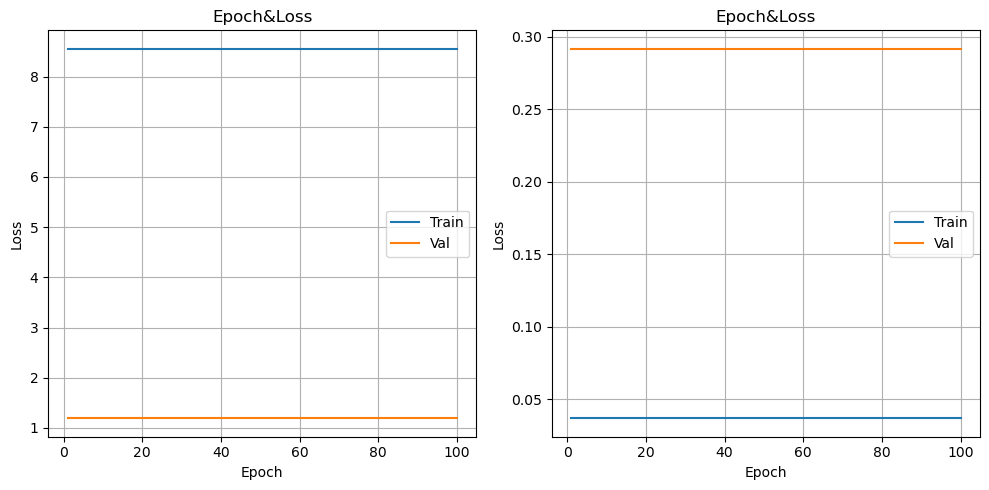

In [143]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=100
fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), loss[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), loss[1][:THRESHOLD], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Epoch&Loss')

axes[1].plot(range(1, THRESHOLD+1), F1[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), F1[1][:THRESHOLD], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Epoch&Loss')
plt.tight_layout()
plt.show()